# Portuguese Syllabifier Comparison
### Rule-Based (`syl.py`) vs. Brill Tagger — Full Benchmark & Analysis

**What this notebook does:**
- Loads the Portuguese Phonetic Lexicon from HuggingFace
- Trains a Brill tagger chain (Unigram → Bigram → Brill) per region
- Runs both syllabifiers across the full dataset
- Produces rich metrics: word-level accuracy, char-level accuracy, syllable count accuracy,
  boundary F1, per-region breakdown, error analysis, latency benchmarks
- Character n-gram analysis of syllable boundaries
- MLflow tracking + optional HuggingFace upload

**Requires:** `syl.py` in the working directory (or set `SYL_PY_PATH` env var).

## 1 · Install Dependencies

In [23]:
!pip install datasets nltk joblib mlflow scikit-learn huggingface_hub onnx onnxruntime onnxscript numpy matplotlib tqdm seaborn

import nltk
nltk.download("punkt", quiet=True)
print("Ready.")


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Ready.


## 2 · Configuration

In [2]:
import os

def _env(key, default=""):  return os.environ.get(key, default)
def _flag(key, default=False):
    return os.environ.get(key, str(default)).lower() in ("1", "true", "yes")

# ── Dataset ───────────────────────────────────────────────────────────────────
REPO_ID          = _env("REPO_ID",          "TigreGotico/portuguese_phonetic_lexicon")
DATASET_SPLIT    = _env("DATASET_SPLIT",    "train")
WORD_COLUMN      = _env("WORD_COLUMN",      "word")
SYLLABLES_COLUMN = _env("SYLLABLES_COLUMN", "syllables")   # pipe-separated: "ca|sa"
REGION_COLUMN    = _env("REGION_COLUMN",    "region_code")
# Comma-separated; empty = all regions
REGIONS          = [r.strip() for r in _env("REGIONS", "lbx").split(",") if r.strip()]

# ── Rule-based syllabifier ────────────────────────────────────────────────────
SYL_PY_PATH      = _env("SYL_PY_PATH",     "/home/miro/PycharmProjects/tugaphone/tugaphone/syl.py")

# ── Brill tagger ──────────────────────────────────────────────────────────────
TEST_SIZE        = float(_env("TEST_SIZE",       "0.1"))
BRILL_MAX_RULES  = int  (_env("BRILL_MAX_RULES", "100"))
BRILL_MIN_SCORE  = int  (_env("BRILL_MIN_SCORE", "3"))
N_JOBS           = int  (_env("N_JOBS",          "-1"))
RANDOM_SEED      = int  (_env("RANDOM_SEED",     "42"))

# ── N-gram analysis ───────────────────────────────────────────────────────────
NGRAM_MAX_N      = int  (_env("NGRAM_MAX_N",     "4"))
NGRAM_TOP_K      = int  (_env("NGRAM_TOP_K",     "20"))  # top-k per chart

# ── Output ────────────────────────────────────────────────────────────────────
OUTPUT_DIR       = _env("OUTPUT_DIR", "./syl_comparison_output")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ── MLflow ────────────────────────────────────────────────────────────────────
MLFLOW_TRACKING_URI = _env("MLFLOW_TRACKING_URI", f"{OUTPUT_DIR}/mlruns")
MLFLOW_EXPERIMENT   = _env("MLFLOW_EXPERIMENT",   "syllabifier_comparison")

# ── HuggingFace ───────────────────────────────────────────────────────────────
HF_TOKEN         = _env("HF_TOKEN", "")
HF_UPLOAD        = _flag("HF_UPLOAD", False)
HF_UPLOAD_REPO   = _env("HF_UPLOAD_REPO", "")

print("Configuration:")
for k, v in [
    ("REPO_ID", REPO_ID), ("REGIONS", REGIONS or "(all)"), ("SYL_PY_PATH", SYL_PY_PATH),
    ("TEST_SIZE", TEST_SIZE), ("BRILL_MAX_RULES", BRILL_MAX_RULES),
    ("NGRAM_MAX_N", NGRAM_MAX_N), ("OUTPUT_DIR", OUTPUT_DIR),
]:
    print(f"  {k:<22} = {v}")

Configuration:
  REPO_ID                = TigreGotico/portuguese_phonetic_lexicon
  REGIONS                = ['lbx']
  SYL_PY_PATH            = /home/miro/PycharmProjects/tugaphone/tugaphone/syl.py
  TEST_SIZE              = 0.1
  BRILL_MAX_RULES        = 100
  NGRAM_MAX_N            = 4
  OUTPUT_DIR             = ./syl_comparison_output


## 3 · Load Rule-Based Syllabifier

In [3]:
import importlib.util, shutil, pathlib

syl_src = pathlib.Path(SYL_PY_PATH).expanduser().resolve()
if not syl_src.exists():
    raise FileNotFoundError(
        f"syl.py not found at '{syl_src}'.\n"
        "Place syl.py in the working directory or set SYL_PY_PATH."
    )

# Copy to cwd so relative imports work
dst = pathlib.Path("syl.py")
if syl_src != dst.resolve():
    shutil.copy(syl_src, dst)

spec = importlib.util.spec_from_file_location("syl", dst)
syl_mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(syl_mod)

rule_syllabify = syl_mod.syllabify   # syllabify(word: str) -> List[str]

# Smoke test
_test = rule_syllabify("computador")
print(f"Rule-based syllabify('computador') → {_test}")
print("Rule-based syllabifier loaded OK.")

Rule-based syllabify('computador') → ['com', 'pu', 'ta', 'dor']
Rule-based syllabifier loaded OK.


## 4 · Load Dataset

In [4]:
import random
from datasets import load_dataset

print(f"Loading '{REPO_ID}' …")
load_kw = {"split": DATASET_SPLIT}
if HF_TOKEN:
    load_kw["token"] = HF_TOKEN

raw = load_dataset(REPO_ID, **load_kw)

entries = [
    row for row in raw
    if row.get(SYLLABLES_COLUMN) and row.get(WORD_COLUMN)
]

random.seed(RANDOM_SEED)
random.shuffle(entries)

all_regions = sorted({r[REGION_COLUMN] for r in entries if REGION_COLUMN in r})
TARGET_REGIONS = REGIONS if REGIONS else all_regions

print(f"Entries (with syllables) : {len(entries):,}")
print(f"All regions              : {all_regions}")
print(f"Training regions         : {TARGET_REGIONS}")

Loading 'TigreGotico/portuguese_phonetic_lexicon' …
Entries (with syllables) : 616,716
All regions              : ['dli', 'lbn', 'lbx', 'lda', 'map', 'mpx', 'rjo', 'rjx', 'spo', 'spx']
Training regions         : ['lbx']


## 5 · Data Helpers

In [5]:
def validate(entry):
    word = entry[WORD_COLUMN]
    syls = entry[SYLLABLES_COLUMN].split("|")
    return "".join(syls).lower() == word.replace("-", "").lower()

def to_bi_labels(word, syllables):
    """Convert syllable list to char-level B/I label sequence."""
    labels = ["I"] * len(word)
    idx = 0
    for s in syllables:
        labels[idx] = "B"
        idx += len(s)
    return labels

def boundary_f1(gold_labels, pred_labels):
    """Binary F1 treating B-positions as positives."""
    tp = sum(g == "B" and p == "B" for g, p in zip(gold_labels, pred_labels))
    fp = sum(g != "B" and p == "B" for g, p in zip(gold_labels, pred_labels))
    fn = sum(g == "B" and p != "B" for g, p in zip(gold_labels, pred_labels))
    prec = tp / (tp + fp) if tp + fp else 0
    rec  = tp / (tp + fn) if tp + fn else 0
    f1   = 2 * prec * rec / (prec + rec) if prec + rec else 0
    return prec, rec, f1

print("Helpers defined.")

Helpers defined.


## 6 · Train Brill Taggers

In [6]:
import joblib
from sklearn.model_selection import train_test_split
from nltk.tag import UnigramTagger, BigramTagger, DefaultTagger, brill, brill_trainer
from joblib import Parallel, delayed

def prepare_region(entries, region):
    X, y = [], []
    for e in entries:
        if e.get(REGION_COLUMN) != region or not validate(e):
            continue
        word = e[WORD_COLUMN]
        syls = e[SYLLABLES_COLUMN].split("|")
        labels = to_bi_labels(word, syls)
        if len(labels) != len(word):
            continue
        X.append(list(word))
        y.append(labels)
    return X, y

def train_brill(region, entries):
    cache = os.path.join(OUTPUT_DIR, f"{region}_brill.pkl")
    X, y = prepare_region(entries, region)
    if not X:
        return None

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED
    )
    train_data = [list(zip(c, l)) for c, l in zip(X_tr, y_tr)]
    test_data  = [list(zip(c, l)) for c, l in zip(X_te, y_te)]

    if os.path.exists(cache):
        tagger = joblib.load(cache)
        print(f"[{region}] loaded cached model")
    else:
        default = DefaultTagger("I")
        uni     = UnigramTagger(train_data, backoff=default)
        bi      = BigramTagger (train_data, backoff=uni)
        trainer = brill_trainer.BrillTaggerTrainer(initial_tagger=bi, templates=brill.fntbl37())
        tagger  = trainer.train(train_data, max_rules=BRILL_MAX_RULES, min_score=BRILL_MIN_SCORE)
        joblib.dump(tagger, cache)
        print(f"[{region}] trained  rules={len(tagger.rules())}")

    acc = tagger.accuracy(test_data)
    return {
        "region": region, "tagger": tagger,
        "X_test": X_te,   "y_test": y_te,
        "X_train": X_tr,  "n_rules": len(tagger.rules()),
        "brill_char_acc": acc,
    }

brill_results = Parallel(n_jobs=N_JOBS, prefer="threads")(
    delayed(train_brill)(r, entries) for r in TARGET_REGIONS
)
brill_map = {r["region"]: r for r in brill_results if r}
print(f"\nBrill models ready: {list(brill_map.keys())}")

[lbx] trained  rules=100

Brill models ready: ['lbx']


## 7 · Run Both Syllabifiers & Collect Metrics

In [7]:
import time, numpy as np
from collections import defaultdict

def brill_syllabify(word_chars, tagger):
    tagged = tagger.tag(word_chars)
    syls, cur = [], ""
    for ch, lbl in tagged:
        lbl = lbl or "I"
        if lbl == "B" and cur:
            syls.append(cur); cur = ""
        cur += ch
    if cur: syls.append(cur)
    return syls

# ── Per-region evaluation ─────────────────────────────────────────────────────
region_metrics = {}   # region → dict of metric arrays
all_errors     = defaultdict(list)   # 'rule'/'brill' → list of (word, gold, pred)

for region, br in brill_map.items():
    tagger = br["tagger"]
    X_test = br["X_test"]
    y_test = br["y_test"]

    (
        rule_word_ok, brill_word_ok,
        rule_char_ok, brill_char_ok,
        rule_count_ok, brill_count_ok,
        total_chars, n_words,
        rule_prec_list, rule_rec_list, rule_f1_list,
        brill_prec_list, brill_rec_list, brill_f1_list,
        rule_lat, brill_lat,
    ) = (
        0, 0, 0, 0, 0, 0, 0, 0,
        [], [], [], [], [], [], [], []
    )

    for chars, gold_labels in zip(X_test, y_test):
        word     = "".join(chars)
        gold_syls = []
        cur = ""
        for ch, lbl in zip(chars, gold_labels):
            if lbl == "B" and cur:
                gold_syls.append(cur); cur = ""
            cur += ch
        if cur: gold_syls.append(cur)

        # ── Rule-based ───────────────────────────────────────────────────────
        t0 = time.perf_counter()
        try:
            rule_syls = rule_syllabify(word)
        except Exception:
            rule_syls = [word]
        rule_lat.append((time.perf_counter() - t0) * 1e6)   # µs

        # ── Brill ────────────────────────────────────────────────────────────
        t0 = time.perf_counter()
        brill_syls = brill_syllabify(chars, tagger)
        brill_lat.append((time.perf_counter() - t0) * 1e6)  # µs

        # ── Labels ───────────────────────────────────────────────────────────
        rule_labels  = []
        brill_labels = []
        for s in rule_syls:  rule_labels.extend(["B"] + ["I"] * (len(s) - 1))
        for s in brill_syls: brill_labels.extend(["B"] + ["I"] * (len(s) - 1))

        # Pad/truncate to match gold length
        L = len(gold_labels)
        rule_labels  = (rule_labels  + ["I"] * L)[:L]
        brill_labels = (brill_labels + ["I"] * L)[:L]

        # ── Aggregate ────────────────────────────────────────────────────────
        r_correct = (rule_labels  == gold_labels)
        b_correct = (brill_labels == gold_labels)

        rule_word_ok  += int(rule_syls  == gold_syls)
        brill_word_ok += int(brill_syls == gold_syls)
        rule_char_ok  += sum(p == g for p, g in zip(rule_labels,  gold_labels))
        brill_char_ok += sum(p == g for p, g in zip(brill_labels, gold_labels))
        rule_count_ok  += int(len(rule_syls)  == len(gold_syls))
        brill_count_ok += int(len(brill_syls) == len(gold_syls))
        total_chars += L
        n_words += 1

        rp, rr, rf = boundary_f1(gold_labels, rule_labels)
        bp, br2, bf = boundary_f1(gold_labels, brill_labels)
        rule_prec_list.append(rp); rule_rec_list.append(rr); rule_f1_list.append(rf)
        brill_prec_list.append(bp); brill_rec_list.append(br2); brill_f1_list.append(bf)

        # Collect errors (first 200 per region)
        if rule_syls != gold_syls and len(all_errors[f"{region}_rule"]) < 200:
            all_errors[f"{region}_rule"].append((word, gold_syls, rule_syls))
        if brill_syls != gold_syls and len(all_errors[f"{region}_brill"]) < 200:
            all_errors[f"{region}_brill"].append((word, gold_syls, brill_syls))

    region_metrics[region] = {
        "n":              n_words,
        "rule_word_acc":  rule_word_ok  / n_words,
        "brill_word_acc": brill_word_ok / n_words,
        "rule_char_acc":  rule_char_ok  / total_chars,
        "brill_char_acc": brill_char_ok / total_chars,
        "rule_count_acc": rule_count_ok  / n_words,
        "brill_count_acc":brill_count_ok / n_words,
        "rule_f1":        float(np.mean(rule_f1_list)),
        "brill_f1":       float(np.mean(brill_f1_list)),
        "rule_prec":      float(np.mean(rule_prec_list)),
        "brill_prec":     float(np.mean(brill_prec_list)),
        "rule_rec":       float(np.mean(rule_rec_list)),
        "brill_rec":      float(np.mean(brill_rec_list)),
        "rule_lat_us":    np.array(rule_lat),
        "brill_lat_us":   np.array(brill_lat),
        "n_brill_rules":  brill_map[region]["n_rules"],
    }

    m = region_metrics[region]
    print(f"[{region:>4}] words={n_words:>5,}  "
          f"rule_word={m['rule_word_acc']:.4f}  brill_word={m['brill_word_acc']:.4f}  "
          f"rule_f1={m['rule_f1']:.4f}  brill_f1={m['brill_f1']:.4f}")

[ lbx] words=6,168  rule_word=0.9720  brill_word=0.9335  rule_f1=0.9982  brill_f1=0.9858


## 8 · Summary Table

In [8]:
import numpy as np

REGIONS_SORTED = sorted(region_metrics.keys())

print(f"{'Region':<7} | {'N':>6} | "
      f"{'Rule Word%':>10} | {'Brill Word%':>11} | "
      f"{'Rule Char%':>10} | {'Brill Char%':>11} | "
      f"{'Rule F1':>8} | {'Brill F1':>9} | "
      f"{'Rule µs p50':>11} | {'Brill µs p50':>12}")
print("-" * 115)

for r in REGIONS_SORTED:
    m = region_metrics[r]
    rl = m["rule_lat_us"];  bl = m["brill_lat_us"]
    print(
        f"{r:<7} | {m['n']:>6,} | "
        f"{m['rule_word_acc']*100:>9.2f}% | {m['brill_word_acc']*100:>10.2f}% | "
        f"{m['rule_char_acc']*100:>9.2f}% | {m['brill_char_acc']*100:>10.2f}% | "
        f"{m['rule_f1']*100:>7.2f}% | {m['brill_f1']*100:>8.2f}% | "
        f"{np.median(rl):>10.1f}  | {np.median(bl):>11.1f}"
    )

Region  |      N | Rule Word% | Brill Word% | Rule Char% | Brill Char% |  Rule F1 |  Brill F1 | Rule µs p50 | Brill µs p50
-------------------------------------------------------------------------------------------------------------------
lbx     |  6,168 |     97.20% |      93.35% |     99.83% |      98.69% |   99.82% |    98.58% |       48.6  |       189.8


## 9 · Plots — Accuracy Comparison

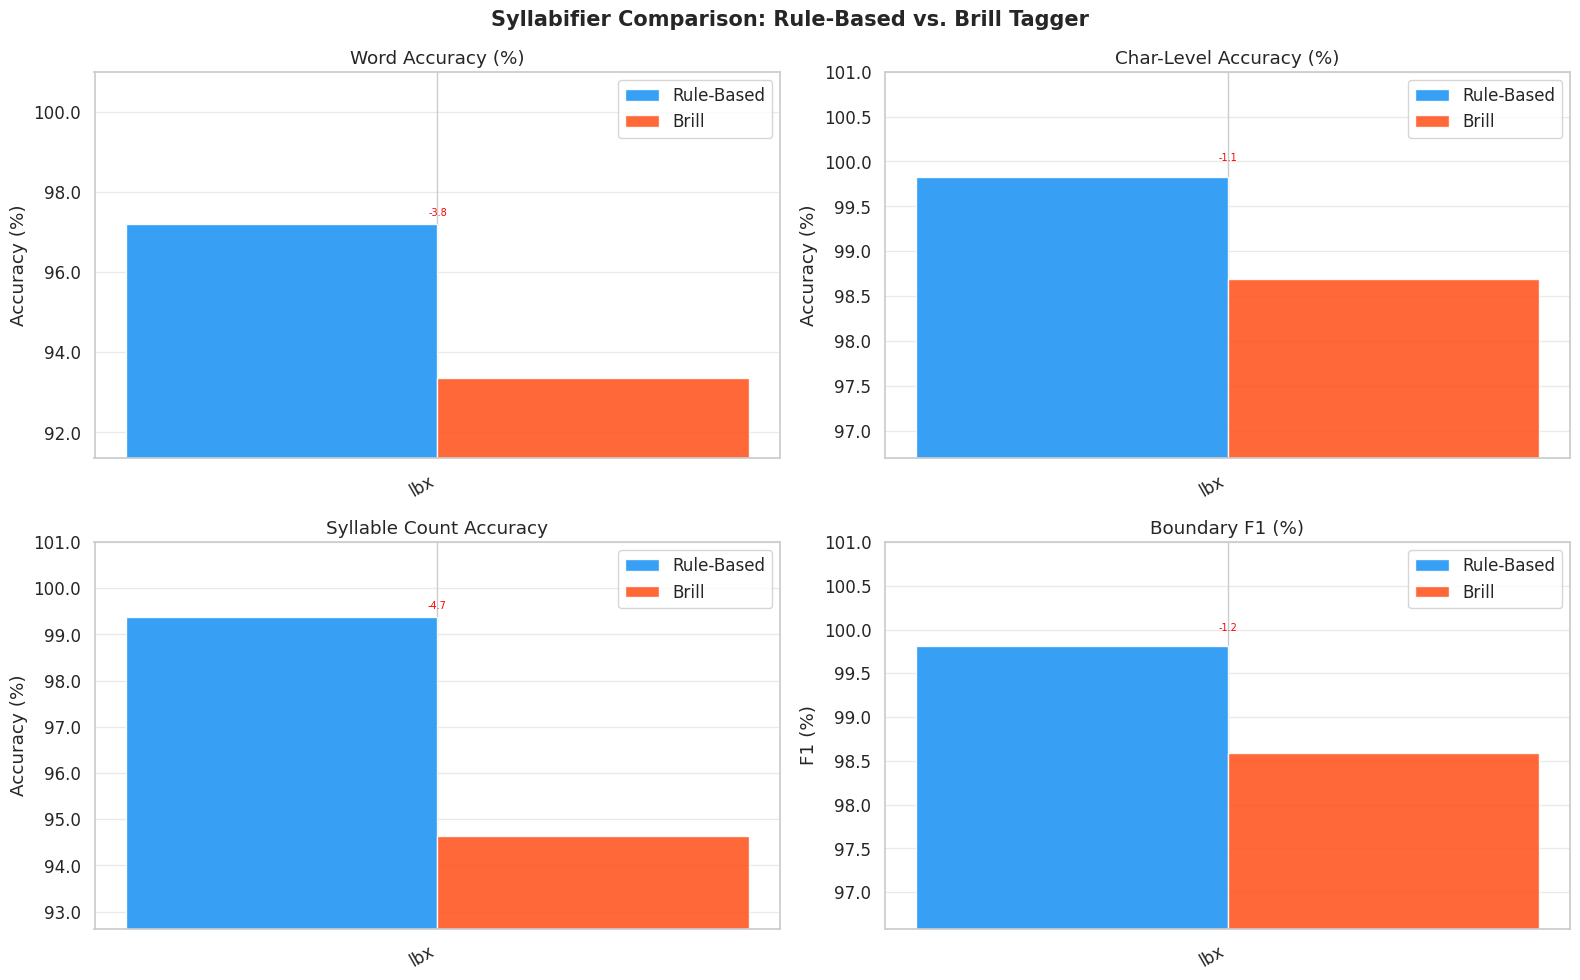

Saved → ./syl_comparison_output/accuracy_comparison.png


In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
RULE_C  = "#2196F3"
BRILL_C = "#FF5722"

x      = np.arange(len(REGIONS_SORTED))
width  = 0.35

rule_word   = [region_metrics[r]["rule_word_acc"]  * 100 for r in REGIONS_SORTED]
brill_word  = [region_metrics[r]["brill_word_acc"] * 100 for r in REGIONS_SORTED]
rule_char   = [region_metrics[r]["rule_char_acc"]  * 100 for r in REGIONS_SORTED]
brill_char  = [region_metrics[r]["brill_char_acc"] * 100 for r in REGIONS_SORTED]
rule_cnt    = [region_metrics[r]["rule_count_acc"] * 100 for r in REGIONS_SORTED]
brill_cnt   = [region_metrics[r]["brill_count_acc"]* 100 for r in REGIONS_SORTED]
rule_f1     = [region_metrics[r]["rule_f1"]        * 100 for r in REGIONS_SORTED]
brill_f1    = [region_metrics[r]["brill_f1"]       * 100 for r in REGIONS_SORTED]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Syllabifier Comparison: Rule-Based vs. Brill Tagger", fontsize=15, fontweight="bold")

def grouped_bar(ax, a_vals, b_vals, title, ylabel, ylim=None):
    bars_a = ax.bar(x - width/2, a_vals, width, label="Rule-Based", color=RULE_C, alpha=0.9)
    bars_b = ax.bar(x + width/2, b_vals, width, label="Brill",      color=BRILL_C, alpha=0.9)
    ax.set_xticks(x); ax.set_xticklabels(REGIONS_SORTED, rotation=30, ha="right")
    ax.set_title(title); ax.set_ylabel(ylabel)
    ax.legend()
    if ylim: ax.set_ylim(*ylim)
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.1f"))
    ax.grid(axis="y", alpha=0.4)
    # Annotate delta
    for xp, a, b in zip(x, a_vals, b_vals):
        delta = b - a
        col = "green" if delta >= 0 else "red"
        ax.annotate(f"{delta:+.1f}", xy=(xp, max(a,b) + 0.15),
                    ha="center", va="bottom", fontsize=7, color=col)

lo = lambda vals: max(0, min(vals) - 2)

grouped_bar(axes[0,0], rule_word,  brill_word,  "Word Accuracy (%)",     "Accuracy (%)", (lo(rule_word+brill_word), 101))
grouped_bar(axes[0,1], rule_char,  brill_char,  "Char-Level Accuracy (%)","Accuracy (%)", (lo(rule_char+brill_char), 101))
grouped_bar(axes[1,0], rule_cnt,   brill_cnt,   "Syllable Count Accuracy","Accuracy (%)", (lo(rule_cnt+brill_cnt),  101))
grouped_bar(axes[1,1], rule_f1,    brill_f1,    "Boundary F1 (%)",        "F1 (%)",        (lo(rule_f1+brill_f1),   101))

plt.tight_layout()
p1 = os.path.join(OUTPUT_DIR, "accuracy_comparison.png")
plt.savefig(p1, dpi=130, bbox_inches="tight"); plt.show()
print(f"Saved → {p1}")

## 10 · Plots — Precision / Recall / F1 Radar

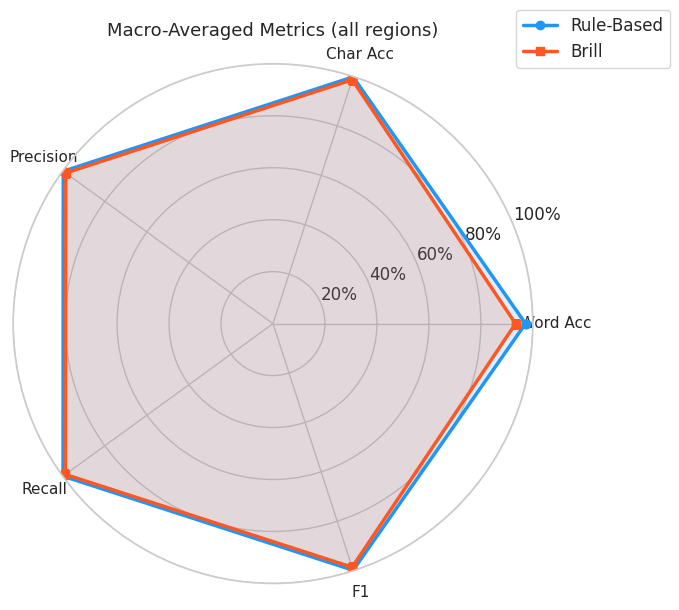

Saved → ./syl_comparison_output/radar.png


In [10]:
from matplotlib.patches import FancyArrowPatch

# Aggregate across all regions (macro average)
agg = {}
for key in ["rule_prec", "brill_prec", "rule_rec", "brill_rec", "rule_f1", "brill_f1",
            "rule_word_acc", "brill_word_acc", "rule_char_acc", "brill_char_acc"]:
    agg[key] = np.mean([region_metrics[r][key] for r in REGIONS_SORTED])

# ── Radar chart ───────────────────────────────────────────────────────────────
categories = ["Word Acc", "Char Acc", "Precision", "Recall", "F1"]
rule_vals  = [
    agg["rule_word_acc"], agg["rule_char_acc"],
    agg["rule_prec"],     agg["rule_rec"],  agg["rule_f1"]
]
brill_vals = [
    agg["brill_word_acc"], agg["brill_char_acc"],
    agg["brill_prec"],     agg["brill_rec"], agg["brill_f1"]
]

N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # close polygon

def close(vals): return vals + [vals[0]]

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))
ax.plot(angles, close(rule_vals),  "o-", color=RULE_C,  lw=2.5, label="Rule-Based")
ax.fill(angles, close(rule_vals),  alpha=0.15, color=RULE_C)
ax.plot(angles, close(brill_vals), "s-", color=BRILL_C, lw=2.5, label="Brill")
ax.fill(angles, close(brill_vals), alpha=0.15, color=BRILL_C)
ax.set_thetagrids(np.degrees(angles[:-1]), categories, fontsize=11)
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))
ax.set_title("Macro-Averaged Metrics (all regions)", fontsize=13, pad=20)
ax.legend(loc="upper right", bbox_to_anchor=(1.28, 1.12))
plt.tight_layout()
p2 = os.path.join(OUTPUT_DIR, "radar.png")
plt.savefig(p2, dpi=130, bbox_inches="tight"); plt.show()
print(f"Saved → {p2}")

## 11 · Plots — Latency Benchmarks

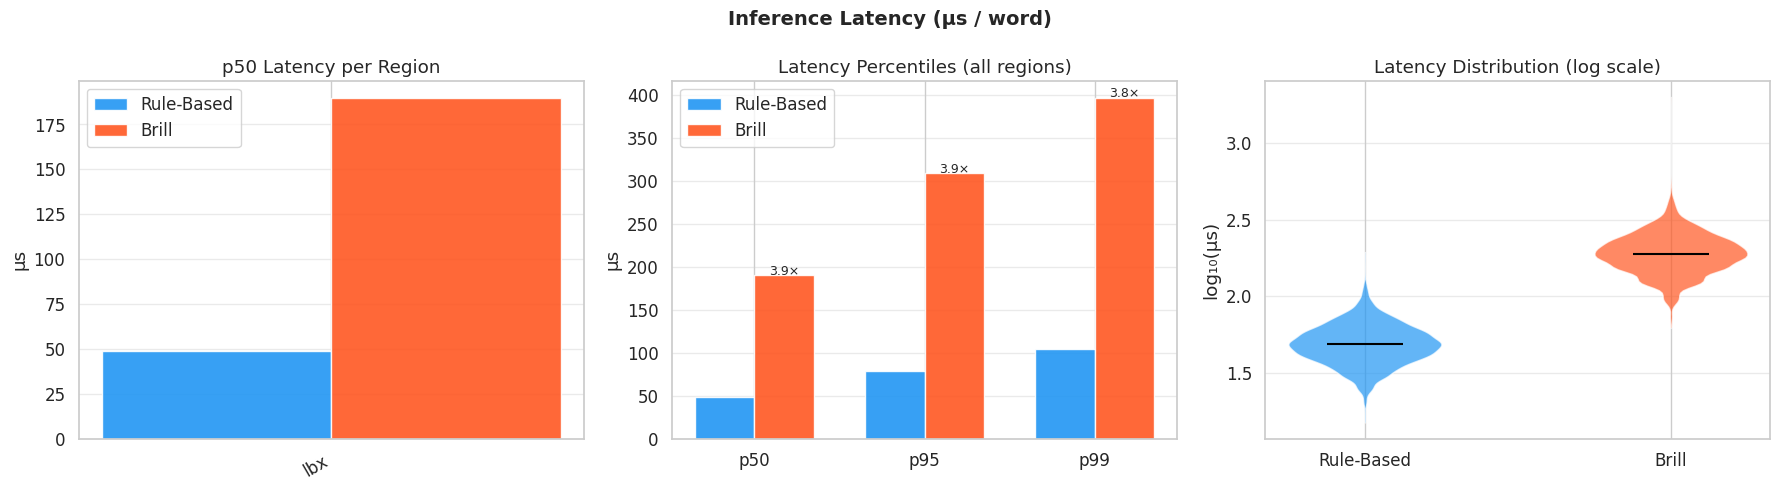

Saved → ./syl_comparison_output/latency.png


In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Inference Latency (µs / word)", fontsize=14, fontweight="bold")

percentiles = [50, 95, 99]

# ── Per-region p50 bar chart ──────────────────────────────────────────────────
ax = axes[0]
r_p50 = [np.percentile(region_metrics[r]["rule_lat_us"],  50) for r in REGIONS_SORTED]
b_p50 = [np.percentile(region_metrics[r]["brill_lat_us"], 50) for r in REGIONS_SORTED]
ax.bar(x - width/2, r_p50, width, label="Rule-Based", color=RULE_C, alpha=0.9)
ax.bar(x + width/2, b_p50, width, label="Brill",      color=BRILL_C, alpha=0.9)
ax.set_xticks(x); ax.set_xticklabels(REGIONS_SORTED, rotation=30, ha="right")
ax.set_title("p50 Latency per Region"); ax.set_ylabel("µs"); ax.legend()
ax.grid(axis="y", alpha=0.4)

# ── Percentile bar chart (aggregated) ────────────────────────────────────────
ax2 = axes[1]
all_rule_lat  = np.concatenate([region_metrics[r]["rule_lat_us"]  for r in REGIONS_SORTED])
all_brill_lat = np.concatenate([region_metrics[r]["brill_lat_us"] for r in REGIONS_SORTED])
pct_x = np.arange(len(percentiles))
r_pcts = [np.percentile(all_rule_lat,  p) for p in percentiles]
b_pcts = [np.percentile(all_brill_lat, p) for p in percentiles]
ax2.bar(pct_x - width/2, r_pcts, width, label="Rule-Based", color=RULE_C, alpha=0.9)
ax2.bar(pct_x + width/2, b_pcts, width, label="Brill",      color=BRILL_C, alpha=0.9)
ax2.set_xticks(pct_x)
ax2.set_xticklabels([f"p{p}" for p in percentiles])
ax2.set_title("Latency Percentiles (all regions)")
ax2.set_ylabel("µs"); ax2.legend(); ax2.grid(axis="y", alpha=0.4)
for xi, rv, bv in zip(pct_x, r_pcts, b_pcts):
    speedup = bv / rv if rv > 0 else 0
    ax2.annotate(f"{speedup:.1f}×", xy=(xi + width/2, bv + 1), ha="center", fontsize=9)

# ── Log-scale violin ─────────────────────────────────────────────────────────
ax3 = axes[2]
sample = min(5000, len(all_rule_lat))
idx_s  = np.random.choice(len(all_rule_lat), sample, replace=False)
data_violin = [
    np.log10(all_rule_lat[idx_s]  + 1e-9),
    np.log10(all_brill_lat[idx_s] + 1e-9),
]
vp = ax3.violinplot(data_violin, positions=[1, 2], showmedians=True, showextrema=False)
for i, (body, col) in enumerate(zip(vp["bodies"], [RULE_C, BRILL_C])):
    body.set_facecolor(col); body.set_alpha(0.7)
vp["cmedians"].set_color("black")
ax3.set_xticks([1, 2]); ax3.set_xticklabels(["Rule-Based", "Brill"])
ax3.set_ylabel("log₁₀(µs)")
ax3.set_title("Latency Distribution (log scale)")
ax3.grid(axis="y", alpha=0.4)

plt.tight_layout()
p3 = os.path.join(OUTPUT_DIR, "latency.png")
plt.savefig(p3, dpi=130, bbox_inches="tight"); plt.show()
print(f"Saved → {p3}")

## 12 · Plots — Error Analysis

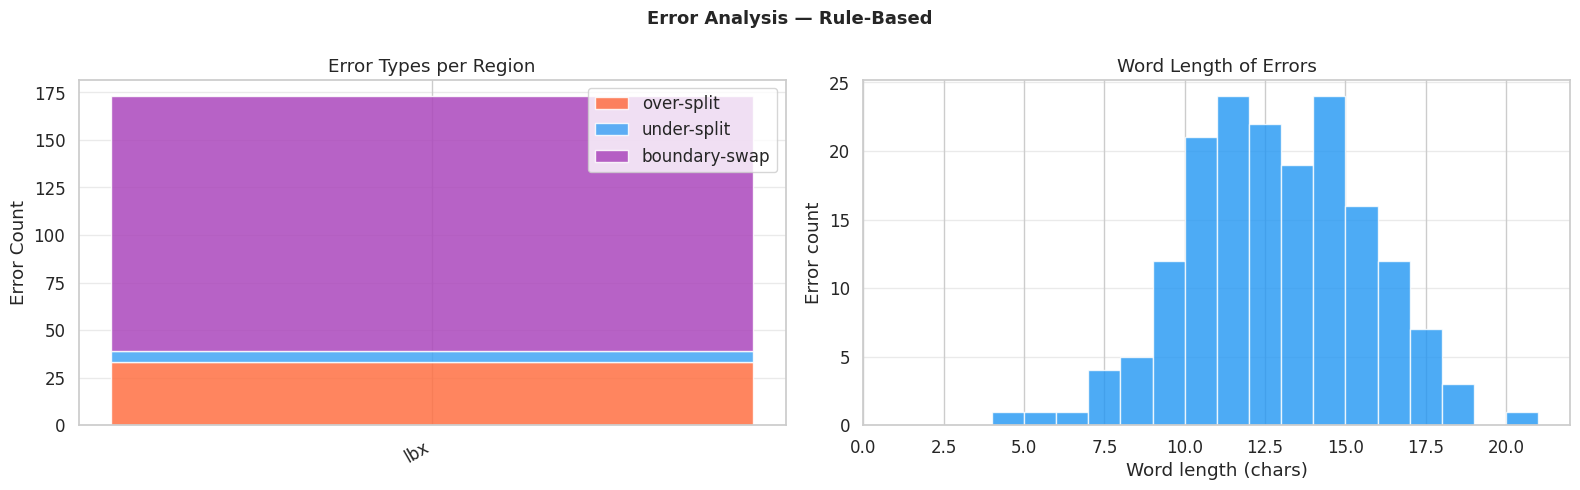

Saved → ./syl_comparison_output/errors_rule.png


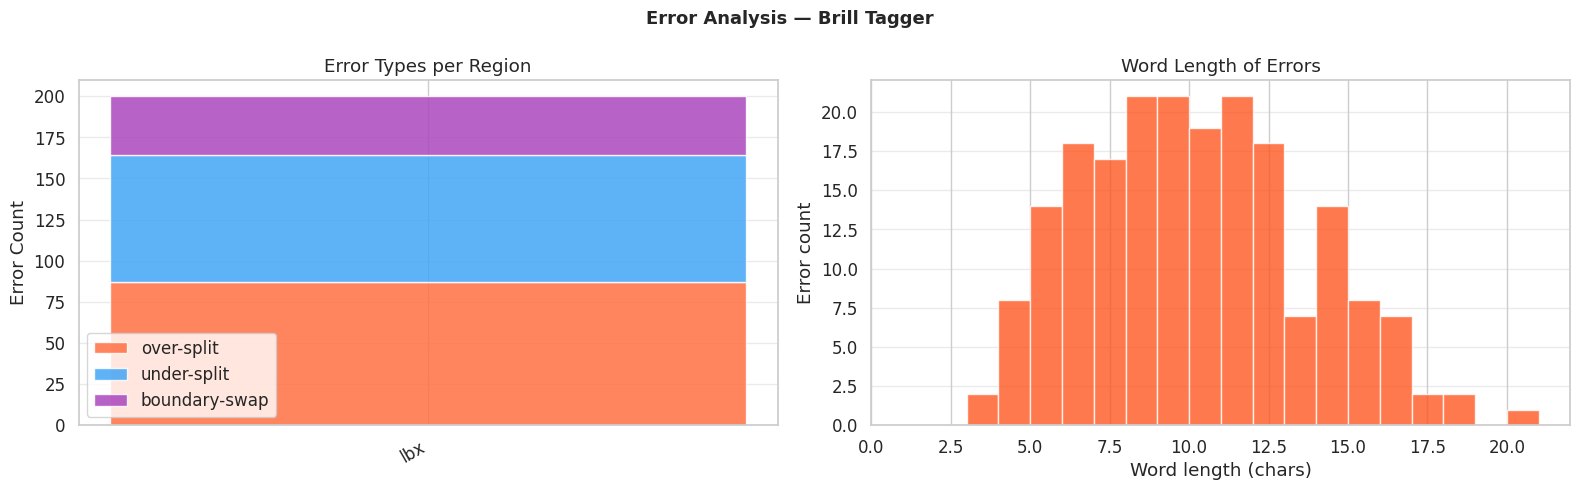

Saved → ./syl_comparison_output/errors_brill.png


In [12]:
from collections import Counter

def error_type(gold_syls, pred_syls):
    """Classify each error into over-split, under-split, or other."""
    if len(pred_syls) > len(gold_syls): return "over-split"
    if len(pred_syls) < len(gold_syls): return "under-split"
    return "boundary-swap"

for model_label in ["rule", "brill"]:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    fig.suptitle(f"Error Analysis — {'Rule-Based' if model_label=='rule' else 'Brill Tagger'}",
                 fontsize=13, fontweight="bold")

    # ── Error type distribution across regions ────────────────────────────────
    ax = axes[0]
    err_types_per_region = {}
    for region in REGIONS_SORTED:
        errs = all_errors.get(f"{region}_{model_label}", [])
        cnt  = Counter(error_type(g, p) for _, g, p in errs)
        err_types_per_region[region] = cnt

    et_labels = ["over-split", "under-split", "boundary-swap"]
    et_colors  = ["#FF7043", "#42A5F5", "#AB47BC"]
    bottom = np.zeros(len(REGIONS_SORTED))
    for label, color in zip(et_labels, et_colors):
        vals = [err_types_per_region[r].get(label, 0) for r in REGIONS_SORTED]
        ax.bar(REGIONS_SORTED, vals, bottom=bottom, label=label, color=color, alpha=0.85)
        bottom += np.array(vals, dtype=float)
    ax.set_title("Error Types per Region")
    ax.set_ylabel("Error Count"); ax.legend()
    ax.grid(axis="y", alpha=0.4)
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    # ── Error word length histogram ───────────────────────────────────────────
    ax2 = axes[1]
    all_err_lens = [
        len(w)
        for region in REGIONS_SORTED
        for w, g, p in all_errors.get(f"{region}_{model_label}", [])
    ]
    if all_err_lens:
        ax2.hist(all_err_lens, bins=range(1, max(all_err_lens)+2), alpha=0.8,
                 color=RULE_C if model_label == "rule" else BRILL_C, edgecolor="white")
    ax2.set_title("Word Length of Errors")
    ax2.set_xlabel("Word length (chars)"); ax2.set_ylabel("Error count")
    ax2.grid(axis="y", alpha=0.4)

    plt.tight_layout()
    pe = os.path.join(OUTPUT_DIR, f"errors_{model_label}.png")
    plt.savefig(pe, dpi=130, bbox_inches="tight"); plt.show()
    print(f"Saved → {pe}")

## 13 · Plots — Syllable Count & Word-Length Accuracy

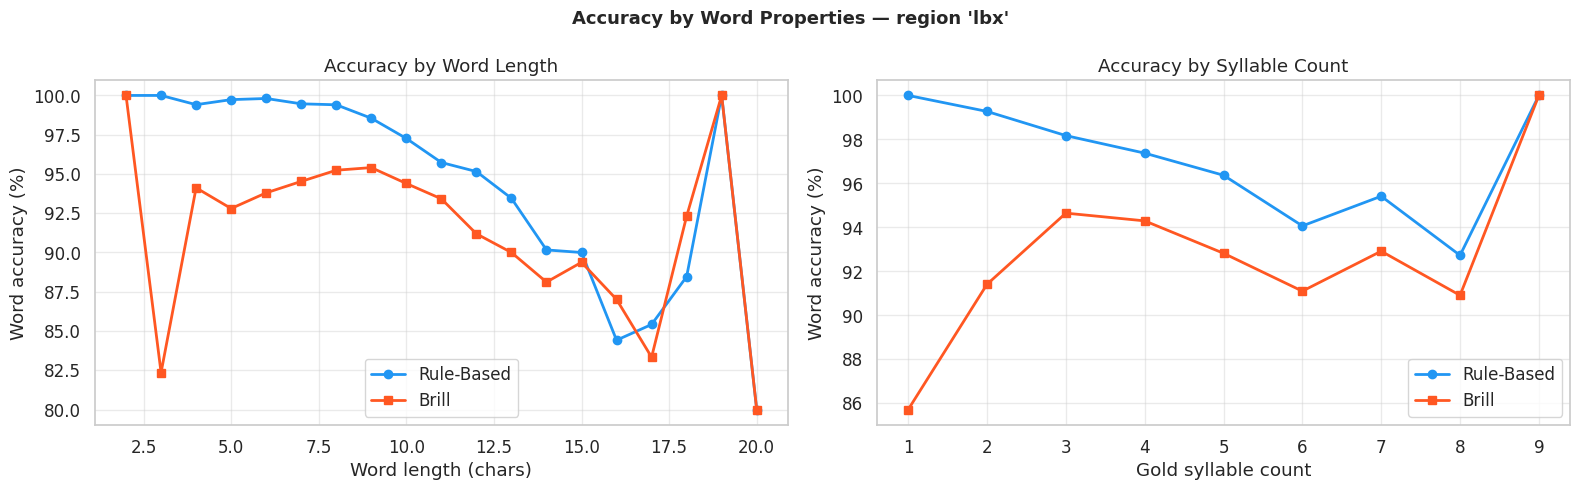

Saved → ./syl_comparison_output/accuracy_by_structure.png


In [13]:
# ── Rebuild per-word data for the first region only (representative) ──────────
SAMPLE_REGION = REGIONS_SORTED[0]
tagger = brill_map[SAMPLE_REGION]["tagger"]
X_test = brill_map[SAMPLE_REGION]["X_test"]
y_test = brill_map[SAMPLE_REGION]["y_test"]

records = []   # (word_len, n_gold_syls, rule_correct, brill_correct)
for chars, gold_labels in zip(X_test, y_test):
    word = "".join(chars)
    gold_syls = []
    cur = ""
    for ch, lbl in zip(chars, gold_labels):
        if lbl == "B" and cur: gold_syls.append(cur); cur = ""
        cur += ch
    if cur: gold_syls.append(cur)

    try:    rule_syls = rule_syllabify(word)
    except: rule_syls = [word]
    brill_syls = brill_syllabify(chars, tagger)

    records.append((
        len(word),
        len(gold_syls),
        int(rule_syls  == gold_syls),
        int(brill_syls == gold_syls),
    ))

import pandas as pd
df = pd.DataFrame(records, columns=["word_len", "n_syls", "rule_ok", "brill_ok"])

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle(f"Accuracy by Word Properties — region '{SAMPLE_REGION}'",
             fontsize=13, fontweight="bold")

# ── By word length ────────────────────────────────────────────────────────────
ax = axes[0]
grp = df.groupby("word_len")[["rule_ok", "brill_ok"]].mean() * 100
cnt = df.groupby("word_len").size()
grp = grp[cnt >= 5]   # only lengths with enough data
ax.plot(grp.index, grp["rule_ok"],  "o-", color=RULE_C,  lw=2, label="Rule-Based")
ax.plot(grp.index, grp["brill_ok"], "s-", color=BRILL_C, lw=2, label="Brill")
ax.set_xlabel("Word length (chars)"); ax.set_ylabel("Word accuracy (%)")
ax.set_title("Accuracy by Word Length"); ax.legend(); ax.grid(alpha=0.4)

# ── By syllable count ─────────────────────────────────────────────────────────
ax2 = axes[1]
grp2 = df.groupby("n_syls")[["rule_ok", "brill_ok"]].mean() * 100
cnt2 = df.groupby("n_syls").size()
grp2 = grp2[cnt2 >= 5]
ax2.plot(grp2.index, grp2["rule_ok"],  "o-", color=RULE_C,  lw=2, label="Rule-Based")
ax2.plot(grp2.index, grp2["brill_ok"], "s-", color=BRILL_C, lw=2, label="Brill")
ax2.set_xlabel("Gold syllable count"); ax2.set_ylabel("Word accuracy (%)")
ax2.set_title("Accuracy by Syllable Count"); ax2.legend(); ax2.grid(alpha=0.4)

plt.tight_layout()
p4 = os.path.join(OUTPUT_DIR, "accuracy_by_structure.png")
plt.savefig(p4, dpi=130, bbox_inches="tight"); plt.show()
print(f"Saved → {p4}")

## 14 · Char N-Gram Analysis of Syllable Boundaries

In [14]:
from collections import Counter

# ── Collect n-grams from the FULL dataset (all regions) across syllable boundaries ──
# We extract:
#   onset_ngrams   — n-grams that START a syllable  (first N chars of each syllable)
#   coda_ngrams    — n-grams that END a syllable    (last N chars of each syllable)
#   boundary_ngrams — n-gram context centred on every B boundary position

def ngram_counter(entries, n, region_filter=None):
    onset, coda, boundary = Counter(), Counter(), Counter()
    for e in entries:
        if region_filter and e.get(REGION_COLUMN) != region_filter:
            continue
        if not validate(e):
            continue
        word = e[WORD_COLUMN].lower()
        syls = e[SYLLABLES_COLUMN].lower().split("|")
        for s in syls:
            if len(s) >= n:
                onset[s[:n]]  += 1
                coda [s[-n:]] += 1
        # Boundary n-grams: window around each boundary in the word
        labels = to_bi_labels(word, syls)
        for i, lbl in enumerate(labels):
            if lbl == "B" and i > 0:   # actual boundary (not first char)
                lo = max(0, i - n + 1)
                hi = min(len(word), i + n)
                context = word[lo:hi]
                boundary[context] += 1
    return onset, coda, boundary


print("Building n-gram counters …")
ngram_data = {}
for n in range(1, NGRAM_MAX_N + 1):
    onset, coda, boundary = ngram_counter(entries, n)
    ngram_data[n] = {"onset": onset, "coda": coda, "boundary": boundary}
    print(f"  n={n}  unique onsets={len(onset):,}  codas={len(coda):,}  boundaries={len(boundary):,}")

Building n-gram counters …
  n=1  unique onsets=38  codas=34  boundaries=36
  n=2  unique onsets=386  codas=438  boundaries=3,611
  n=3  unique onsets=1,295  codas=1,362  boundaries=34,004
  n=4  unique onsets=542  codas=546  boundaries=70,097


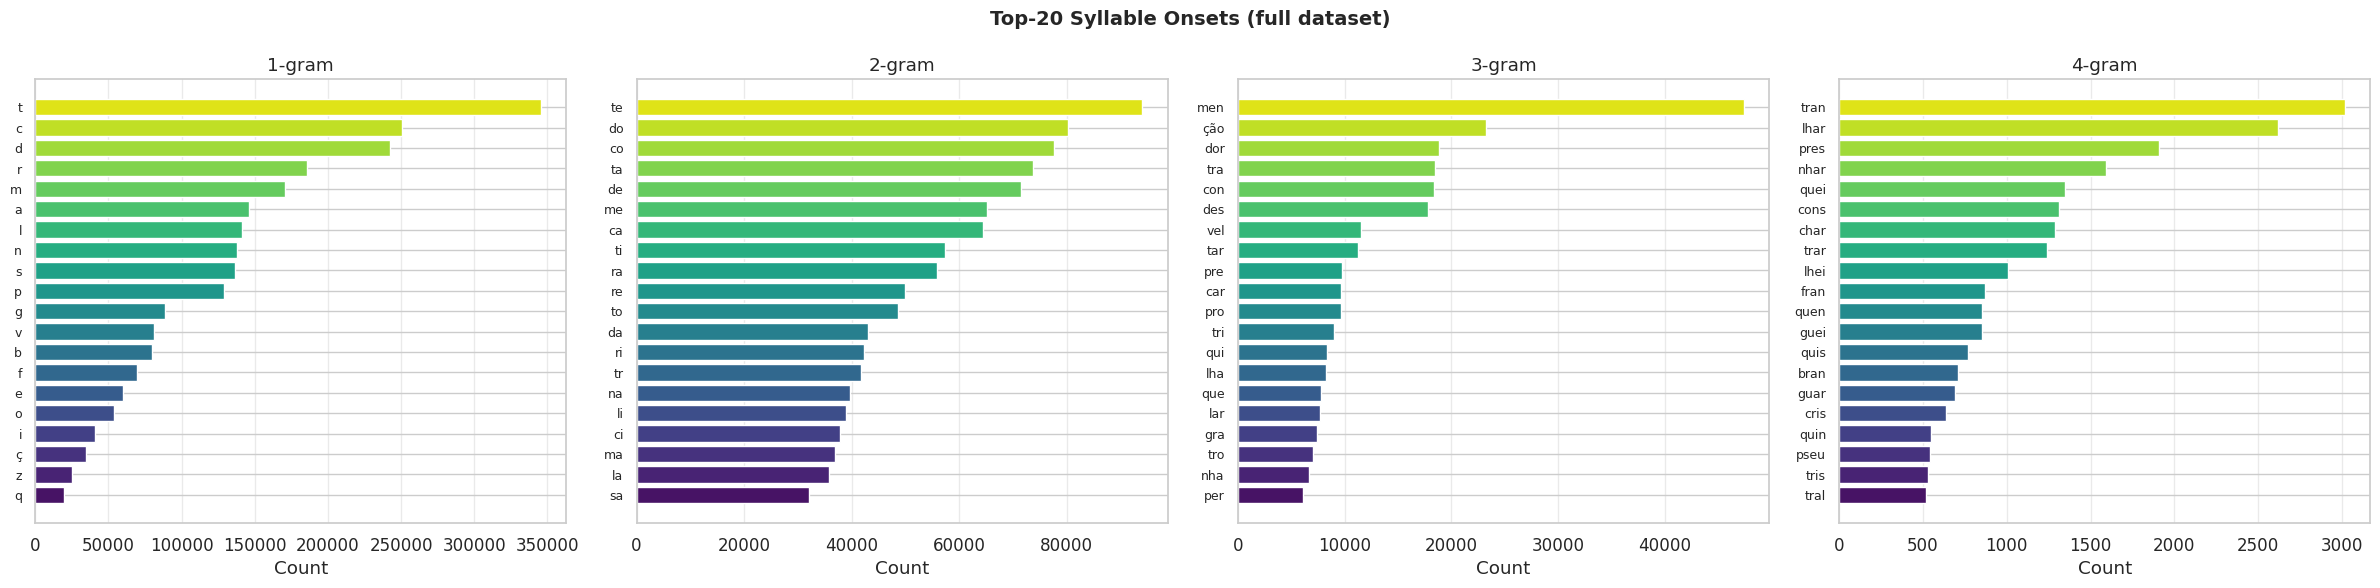

Saved → ./syl_comparison_output/ngram_onset.png


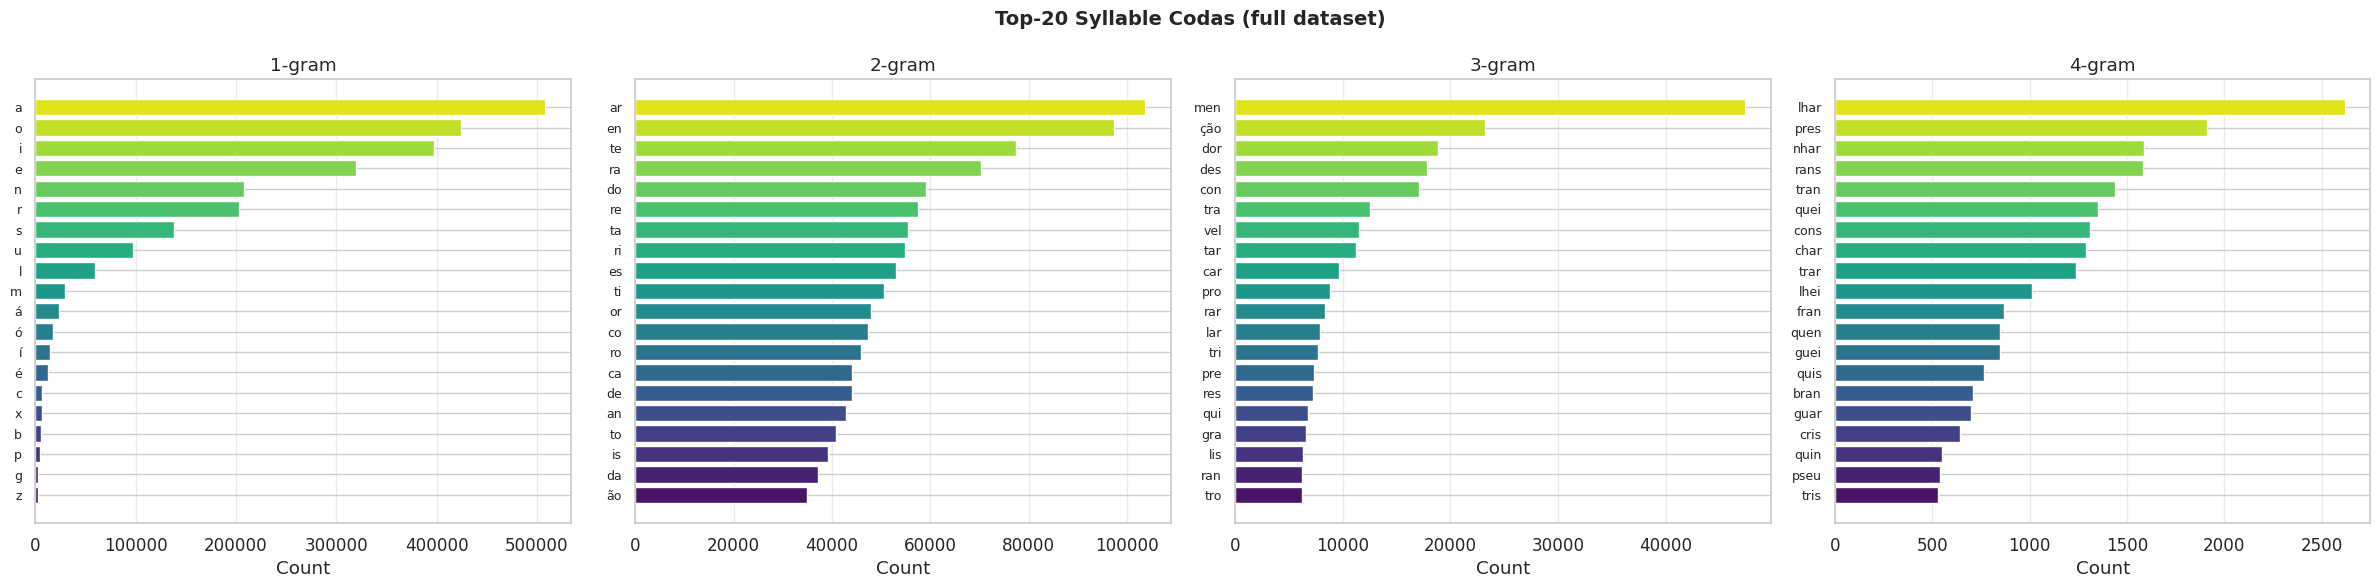

Saved → ./syl_comparison_output/ngram_coda.png


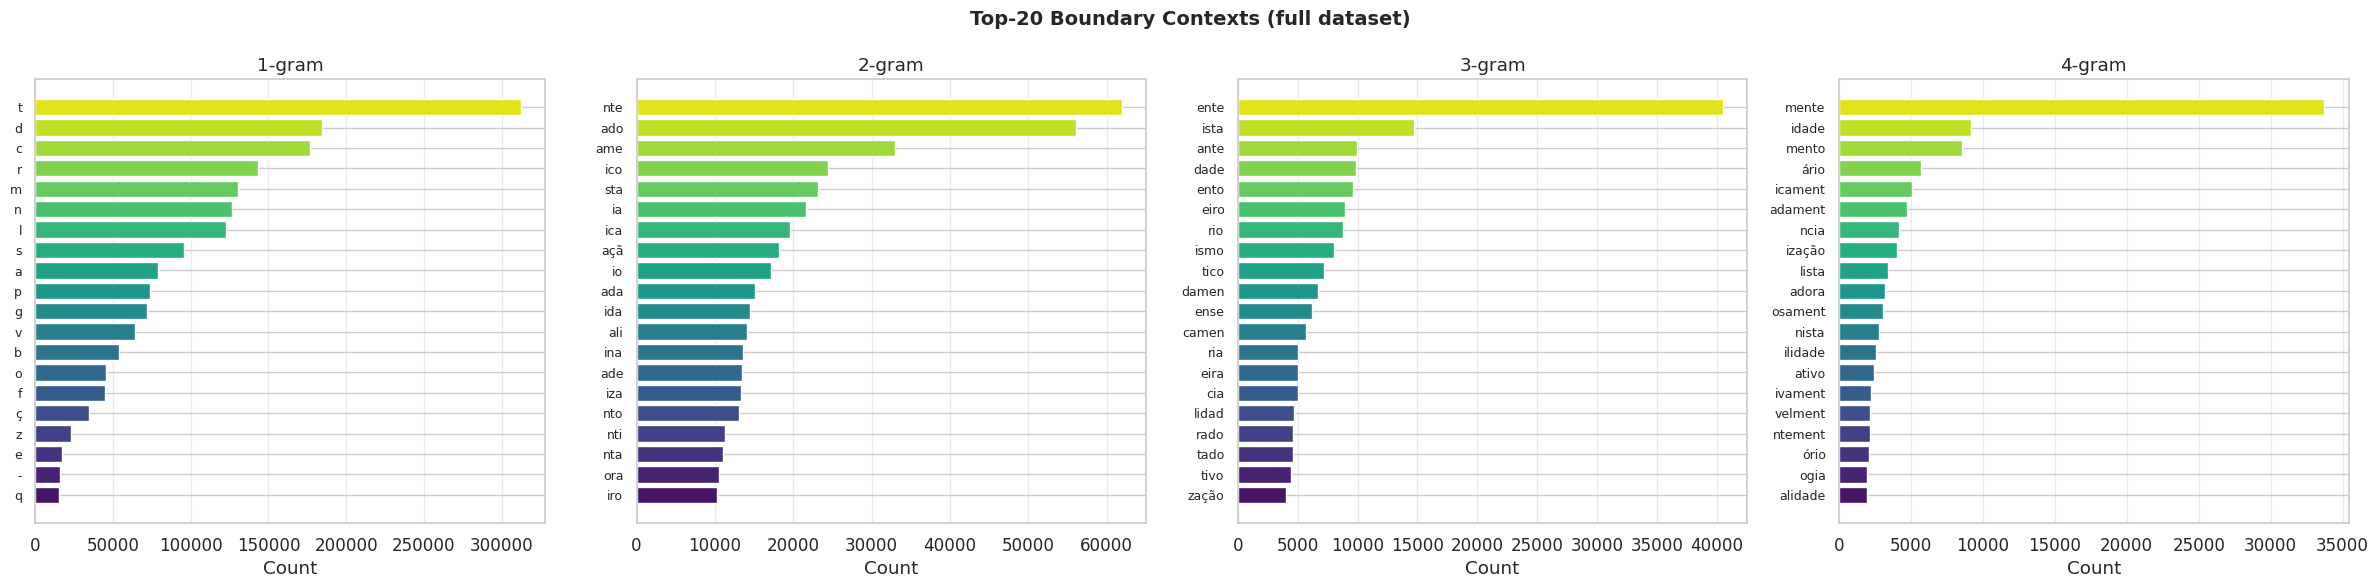

Saved → ./syl_comparison_output/ngram_boundary.png


In [15]:
# ── Plot top-k n-grams for each type and each n ───────────────────────────────

for ngram_type, title_label in [("onset", "Syllable Onsets"),
                                 ("coda",  "Syllable Codas"),
                                 ("boundary", "Boundary Contexts")]:
    fig, axes = plt.subplots(1, NGRAM_MAX_N, figsize=(6 * NGRAM_MAX_N, 6))
    fig.suptitle(f"Top-{NGRAM_TOP_K} {title_label} (full dataset)",
                 fontsize=14, fontweight="bold")
    for ni, n in enumerate(range(1, NGRAM_MAX_N + 1)):
        ax = axes[ni]
        top = ngram_data[n][ngram_type].most_common(NGRAM_TOP_K)
        if not top:
            ax.set_visible(False); continue
        labels_g, vals_g = zip(*top)
        colors = sns.color_palette("viridis", len(labels_g))
        ax.barh(range(len(labels_g)), vals_g, color=colors[::-1])
        ax.set_yticks(range(len(labels_g)))
        ax.set_yticklabels(labels_g, fontsize=9)
        ax.invert_yaxis()
        ax.set_title(f"{n}-gram")
        ax.set_xlabel("Count")
        ax.grid(axis="x", alpha=0.4)
    plt.tight_layout()
    pn = os.path.join(OUTPUT_DIR, f"ngram_{ngram_type}.png")
    plt.savefig(pn, dpi=130, bbox_inches="tight"); plt.show()
    print(f"Saved → {pn}")

## 15 · Plots — N-Gram Frequency vs. Accuracy Heatmap

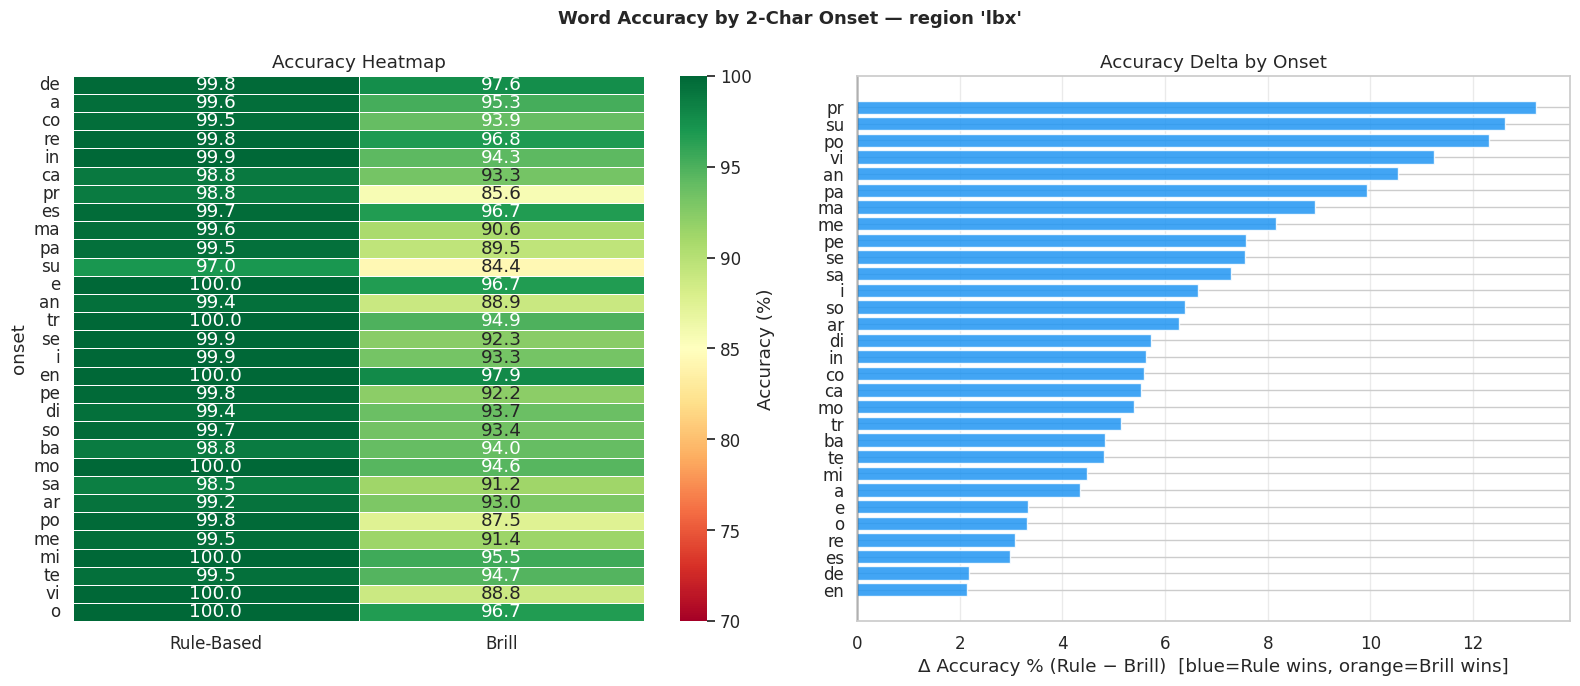

Saved → ./syl_comparison_output/onset_heatmap.png


In [16]:
# For n=1 and n=2 onsets: check if a specific onset predicts model accuracy differences
# ─────────────────────────────────────────────────────────────────────────────
SAMPLE_REGION2 = REGIONS_SORTED[0]
tagger2 = brill_map[SAMPLE_REGION2]["tagger"]

onset_acc = {}  # onset_gram -> {rule_ok, brill_ok, count}

for e in entries:
    if e.get(REGION_COLUMN) != SAMPLE_REGION2 or not validate(e):
        continue
    word = e[WORD_COLUMN]
    syls = e[SYLLABLES_COLUMN].split("|")
    first_onset = syls[0][:2].lower() if syls else "?"

    try:    rule_syls = rule_syllabify(word)
    except: rule_syls = [word]
    brill_syls = brill_syllabify(list(word), tagger2)

    rule_ok  = int(rule_syls  == syls)
    brill_ok = int(brill_syls == syls)

    if first_onset not in onset_acc:
        onset_acc[first_onset] = {"rule": 0, "brill": 0, "n": 0}
    onset_acc[first_onset]["rule"]  += rule_ok
    onset_acc[first_onset]["brill"] += brill_ok
    onset_acc[first_onset]["n"]     += 1

# Build heatmap dataframe
rows = [
    {"onset": k, "rule_acc": v["rule"]/v["n"], "brill_acc": v["brill"]/v["n"], "n": v["n"]}
    for k, v in onset_acc.items() if v["n"] >= 20
]
df_onset = pd.DataFrame(rows).sort_values("n", ascending=False).head(30)
df_onset["delta"] = df_onset["rule_acc"] - df_onset["brill_acc"]

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle(f"Word Accuracy by 2-Char Onset — region '{SAMPLE_REGION2}'",
             fontsize=13, fontweight="bold")

# Heatmap: [onsets x model]
hm_data = df_onset[["rule_acc", "brill_acc"]].set_index(df_onset["onset"]) * 100
sns.heatmap(hm_data, ax=axes[0], annot=True, fmt=".1f", cmap="RdYlGn",
            vmin=70, vmax=100, linewidths=0.5, cbar_kws={"label": "Accuracy (%)"})
axes[0].set_title("Accuracy Heatmap")
axes[0].set_xticklabels(["Rule-Based", "Brill"], rotation=0)

# Delta bar (Rule - Brill): positive = rule wins
df_plot = df_onset.sort_values("delta")
colors = [RULE_C if d >= 0 else BRILL_C for d in df_plot["delta"]]
axes[1].barh(df_plot["onset"], df_plot["delta"] * 100, color=colors, alpha=0.85)
axes[1].axvline(0, color="black", lw=1)
axes[1].set_xlabel("Δ Accuracy % (Rule − Brill)  [blue=Rule wins, orange=Brill wins]")
axes[1].set_title("Accuracy Delta by Onset")
axes[1].grid(axis="x", alpha=0.4)

plt.tight_layout()
p5 = os.path.join(OUTPUT_DIR, "onset_heatmap.png")
plt.savefig(p5, dpi=130, bbox_inches="tight"); plt.show()
print(f"Saved → {p5}")

## 16 · Plots — Dataset N-Gram Distributions (Unigram entropy, bigram coverage)

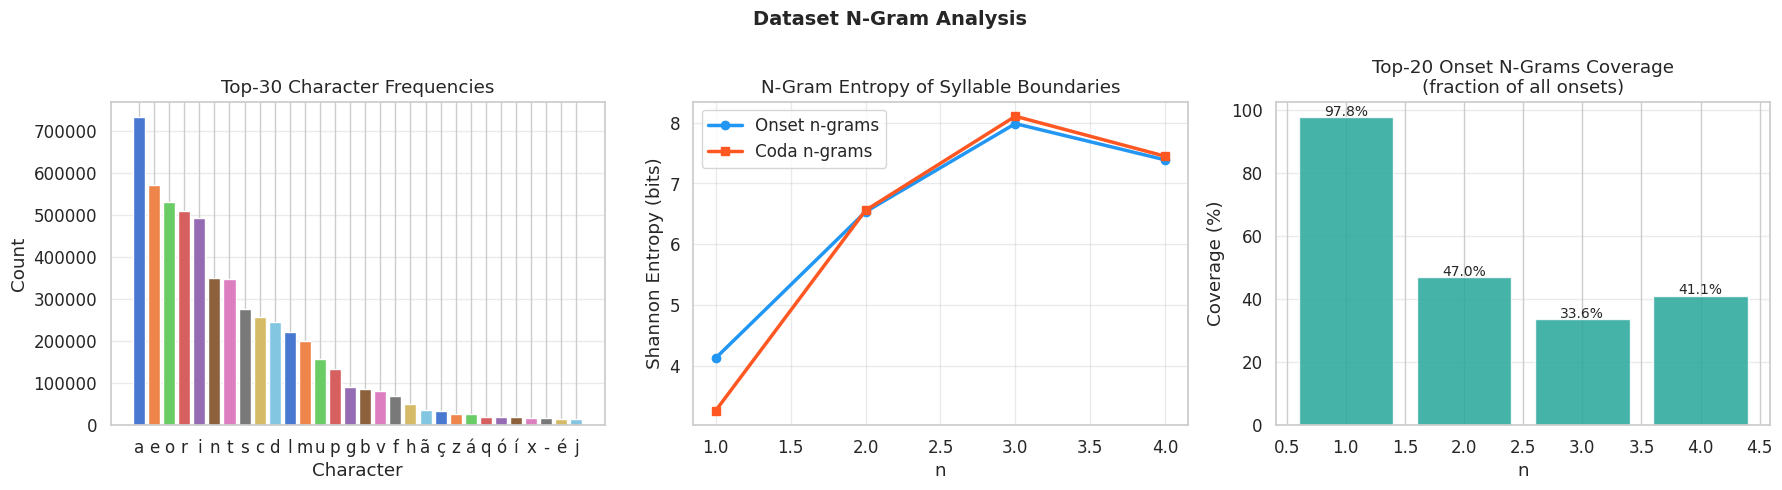

Saved → ./syl_comparison_output/ngram_stats.png


In [17]:
from scipy.stats import entropy as sp_entropy
import warnings; warnings.filterwarnings("ignore")

# ── Unigram char frequency ────────────────────────────────────────────────────
char_freq = Counter()
for e in entries:
    for ch in e[WORD_COLUMN].lower():
        char_freq[ch] += 1

# ── Entropy per n ─────────────────────────────────────────────────────────────
entropy_onset    = []
entropy_coda     = []
coverage_onset   = []   # fraction of dataset tokens covered by top-20 grams
for n in range(1, NGRAM_MAX_N + 1):
    o_vals = np.array(list(ngram_data[n]["onset"].values()), dtype=float)
    c_vals = np.array(list(ngram_data[n]["coda"].values()),  dtype=float)
    entropy_onset.append(sp_entropy(o_vals / o_vals.sum(), base=2))
    entropy_coda.append (sp_entropy(c_vals / c_vals.sum(), base=2))
    top20 = sum(v for _, v in ngram_data[n]["onset"].most_common(20))
    total = o_vals.sum()
    coverage_onset.append(top20 / total if total else 0)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Dataset N-Gram Analysis", fontsize=14, fontweight="bold")

# ── Char frequency distribution ───────────────────────────────────────────────
ax = axes[0]
top_chars = char_freq.most_common(30)
chars_l, chars_v = zip(*top_chars)
ax.bar(chars_l, chars_v, color=sns.color_palette("muted", len(chars_l)))
ax.set_title("Top-30 Character Frequencies")
ax.set_xlabel("Character"); ax.set_ylabel("Count")
ax.grid(axis="y", alpha=0.4)

# ── Entropy by n ──────────────────────────────────────────────────────────────
ax2 = axes[1]
ns = list(range(1, NGRAM_MAX_N + 1))
ax2.plot(ns, entropy_onset, "o-", color=RULE_C,  lw=2.5, label="Onset n-grams")
ax2.plot(ns, entropy_coda,  "s-", color=BRILL_C, lw=2.5, label="Coda n-grams")
ax2.set_xlabel("n"); ax2.set_ylabel("Shannon Entropy (bits)")
ax2.set_title("N-Gram Entropy of Syllable Boundaries")
ax2.legend(); ax2.grid(alpha=0.4)

# ── Top-20 coverage by n ──────────────────────────────────────────────────────
ax3 = axes[2]
ax3.bar(ns, [c * 100 for c in coverage_onset], color="#26A69A", alpha=0.85)
ax3.set_xlabel("n"); ax3.set_ylabel("Coverage (%)")
ax3.set_title("Top-20 Onset N-Grams Coverage\n(fraction of all onsets)")
ax3.grid(axis="y", alpha=0.4)
for i, v in enumerate(coverage_onset):
    ax3.text(i + 1, v * 100 + 0.5, f"{v*100:.1f}%", ha="center", fontsize=10)

plt.tight_layout()
p6 = os.path.join(OUTPUT_DIR, "ngram_stats.png")
plt.savefig(p6, dpi=130, bbox_inches="tight"); plt.show()
print(f"Saved → {p6}")

## 17 · Plots — Brill Rules Heatmap & Syllable Length Distribution

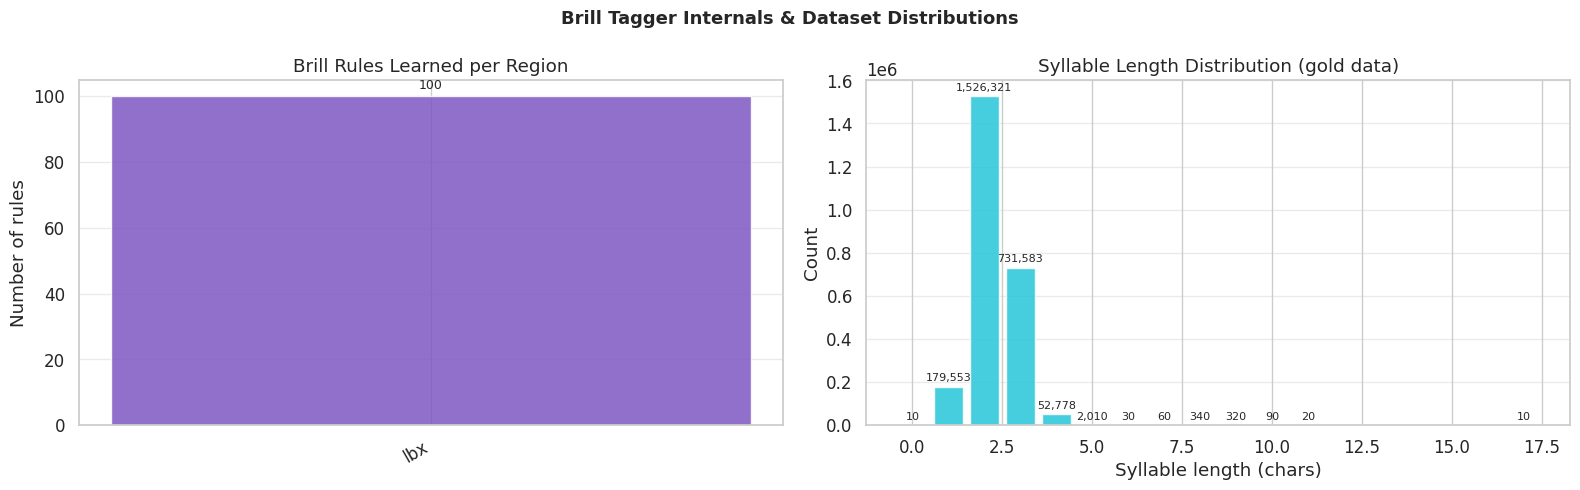

Saved → ./syl_comparison_output/brill_rules_and_syl_dist.png


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Brill Tagger Internals & Dataset Distributions", fontsize=13, fontweight="bold")

# ── Brill rules per region ────────────────────────────────────────────────────
ax = axes[0]
n_rules_list = [brill_map[r]["n_rules"] for r in REGIONS_SORTED]
bars = ax.bar(REGIONS_SORTED, n_rules_list, color="#7E57C2", alpha=0.85)
ax.bar_label(bars, fmt="%d", padding=3, fontsize=9)
ax.set_title("Brill Rules Learned per Region")
ax.set_ylabel("Number of rules")
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
ax.grid(axis="y", alpha=0.4)

# ── Syllable length distribution in gold data ─────────────────────────────────
ax2 = axes[1]
syl_len_counter = Counter()
for e in entries:
    if not validate(e): continue
    for s in e[SYLLABLES_COLUMN].split("|"):
        syl_len_counter[len(s)] += 1

syl_lens = sorted(syl_len_counter)
syl_cnts = [syl_len_counter[l] for l in syl_lens]
ax2.bar(syl_lens, syl_cnts, color="#26C6DA", alpha=0.85, edgecolor="white")
ax2.set_title("Syllable Length Distribution (gold data)")
ax2.set_xlabel("Syllable length (chars)"); ax2.set_ylabel("Count")
ax2.grid(axis="y", alpha=0.4)
for l, c in zip(syl_lens, syl_cnts):
    ax2.text(l, c + max(syl_cnts)*0.01, f"{c:,}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
p7 = os.path.join(OUTPUT_DIR, "brill_rules_and_syl_dist.png")
plt.savefig(p7, dpi=130, bbox_inches="tight"); plt.show()
print(f"Saved → {p7}")

## 18 · Plots — Agreement / Disagreement Matrix

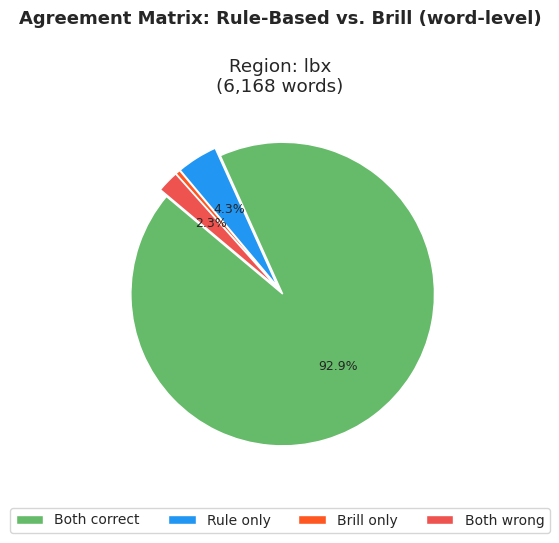

Saved → ./syl_comparison_output/agreement_matrix.png


In [19]:
# Four-way breakdown: both correct, only rule correct, only brill correct, both wrong

fig, axes = plt.subplots(1, len(REGIONS_SORTED), figsize=(5 * len(REGIONS_SORTED), 5))
if len(REGIONS_SORTED) == 1:
    axes = [axes]

for ax, region in zip(axes, REGIONS_SORTED):
    tagger_r = brill_map[region]["tagger"]
    X_te = brill_map[region]["X_test"]
    y_te = brill_map[region]["y_test"]

    both_ok = rule_only = brill_only = both_wrong = 0
    for chars, gold_labels in zip(X_te, y_te):
        word = "".join(chars)
        gold_syls = []
        cur = ""
        for ch, lbl in zip(chars, gold_labels):
            if lbl == "B" and cur: gold_syls.append(cur); cur = ""
            cur += ch
        if cur: gold_syls.append(cur)

        try:    r_syls = rule_syllabify(word)
        except: r_syls = [word]
        b_syls = brill_syllabify(chars, tagger_r)

        r_ok = (r_syls == gold_syls)
        b_ok = (b_syls == gold_syls)
        if r_ok and b_ok:       both_ok    += 1
        elif r_ok and not b_ok: rule_only  += 1
        elif not r_ok and b_ok: brill_only += 1
        else:                   both_wrong += 1

    labels = ["Both correct", "Rule only", "Brill only", "Both wrong"]
    sizes  = [both_ok, rule_only, brill_only, both_wrong]
    colors = ["#66BB6A", RULE_C, BRILL_C, "#EF5350"]
    explode= [0.03] * 4

    wedges, _, autotexts = ax.pie(
        sizes, labels=None, colors=colors, explode=explode,
        autopct=lambda p: f"{p:.1f}%" if p > 1 else "",
        startangle=140, textprops={"fontsize": 9}
    )
    ax.set_title(f"Region: {region}\n({sum(sizes):,} words)")

# Shared legend
from matplotlib.patches import Patch
legend_patches = [Patch(facecolor=c, label=l) for c, l in zip(colors, labels)]
fig.legend(handles=legend_patches, loc="lower center", ncol=4, fontsize=10,
           bbox_to_anchor=(0.5, -0.08))
fig.suptitle("Agreement Matrix: Rule-Based vs. Brill (word-level)",
             fontsize=13, fontweight="bold")
plt.tight_layout()
p8 = os.path.join(OUTPUT_DIR, "agreement_matrix.png")
plt.savefig(p8, dpi=130, bbox_inches="tight"); plt.show()
print(f"Saved → {p8}")

## 19 · MLflow Tracking

In [20]:
import mlflow

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT)

all_plots = [p1, p2, p3, p4, p5, p6, p7, p8]

for region in REGIONS_SORTED:
    m = region_metrics[region]

    for model_label in ["rule", "brill"]:
        with mlflow.start_run(run_name=f"{region}_{model_label}"):
            mlflow.log_params({
                "region": region, "model": model_label,
                "repo_id": REPO_ID, "test_size": TEST_SIZE,
                "brill_max_rules": BRILL_MAX_RULES if model_label == "brill" else "N/A",
                "n_brill_rules": m["n_brill_rules"] if model_label == "brill" else "N/A",
            })
            mlflow.log_metrics({
                "word_acc":  m[f"{model_label}_word_acc"],
                "char_acc":  m[f"{model_label}_char_acc"],
                "count_acc": m[f"{model_label}_count_acc"],
                "precision": m[f"{model_label}_prec"],
                "recall":    m[f"{model_label}_rec"],
                "f1":        m[f"{model_label}_f1"],
                "lat_p50_us": float(np.median(m[f"{model_label}_lat_us"])),
                "lat_p99_us": float(np.percentile(m[f"{model_label}_lat_us"], 99)),
            })
            for plot in all_plots:
                if os.path.exists(plot):
                    mlflow.log_artifact(plot, artifact_path="plots")

print("MLflow runs logged.")

2026/02/18 23:34:58 INFO mlflow.tracking.fluent: Experiment with name 'syllabifier_comparison' does not exist. Creating a new experiment.


MLflow runs logged.


## 20 · HuggingFace Upload (optional)

In [21]:
if HF_UPLOAD:
    if not HF_TOKEN or not HF_UPLOAD_REPO:
        print("Set HF_TOKEN and HF_UPLOAD_REPO to upload.")
    else:
        from huggingface_hub import HfApi
        api = HfApi(token=HF_TOKEN)
        api.create_repo(HF_UPLOAD_REPO, repo_type="model", exist_ok=True)
        for p in all_plots:
            if os.path.exists(p):
                api.upload_file(
                    path_or_fileobj=p,
                    path_in_repo=f"plots/{os.path.basename(p)}",
                    repo_id=HF_UPLOAD_REPO, repo_type="model"
                )
        print(f"Uploaded to https://huggingface.co/{HF_UPLOAD_REPO}")
else:
    print("HF_UPLOAD=False – skipping.")

HF_UPLOAD=False – skipping.


## 21 · Sample Error Cases

In [22]:
SHOW_N = 20

for region in REGIONS_SORTED[:2]:   # show first 2 regions
    print(f"\n{'─'*70}")
    print(f"Region: {region}  — errors where models DISAGREE")
    print(f"{'─'*70}")
    print(f"{'Word':<20}  {'Gold':<20}  {'Rule':<20}  {'Brill':<20}")
    print("-" * 80)

    tagger_r = brill_map[region]["tagger"]
    disagree = []
    for e in entries:
        if e.get(REGION_COLUMN) != region or not validate(e): continue
        word = e[WORD_COLUMN]
        gold = e[SYLLABLES_COLUMN].split("|")
        try:    r = rule_syllabify(word)
        except: r = [word]
        b = brill_syllabify(list(word), tagger_r)
        if r != b:   # models disagree
            disagree.append((word, gold, r, b))
        if len(disagree) >= SHOW_N: break

    for word, gold, r, b in disagree:
        g_s = "|".join(gold)
        r_s = "|".join(r)
        b_s = "|".join(b)
        r_ok = "✓" if r == gold else "✗"
        b_ok = "✓" if b == gold else "✗"
        print(f"{word:<20}  {g_s:<20}  {r_ok}{r_s:<19}  {b_ok}{b_s:<19}")


──────────────────────────────────────────────────────────────────────
Region: lbx  — errors where models DISAGREE
──────────────────────────────────────────────────────────────────────
Word                  Gold                  Rule                  Brill               
--------------------------------------------------------------------------------
redil                 re|dil                ✓re|dil               ✗re|di|l            
azevém                a|ze|vém              ✓a|ze|vém             ✗a|ze|vé|m          
galinha-da-índia      ga|li|nha|da|ín|di|a  ✓ga|li|nha|da|ín|di|a  ✗ga|li|nha|-da-índi|a
contraoitava          con|traoi|ta|va       ✗con|tra|oi|ta|va     ✓con|traoi|ta|va    
estatuir              es|ta|tu|ir           ✓es|ta|tu|ir          ✗es|ta|tuir         
alto-falante          al|to|fa|lan|te       ✓al|to|fa|lan|te      ✗al|to|-falan|te    
boca de incêndio      bo|ca de in|cên|di|o  ✗bo|ca|de|in|cên|di|o  ✓bo|ca de in|cên|di|o
vice-cônsul           vi|ce|côn|